In [1]:
import os
import polars as pl
from typing import Any

while not os.getcwd().endswith("nlp-playground"):
    os.chdir("..")
print(os.getcwd())

from notebooks.price_cube.enums import Category, Column
import matplotlib.pyplot as plt
from notebooks.price_cube.environment import Environment
import numpy as np
from notebooks.price_cube.utils import to_camel_case
from scipy.optimize import minimize_scalar
import json
from notebooks.price_cube.constants import (
    PRODUCT_PRICE_RANGES_CONSTRAINTS,
)
from notebooks.price_cube.models import (
    Point,
    ModalSkuData,
    PricingOptimizationRecap,
    DashboardPlots,
)

/Users/cristian/Personal/Projects/nlp-playground


In [6]:
BASE_DIR = os.path.join("notebooks", "price_cube")
DATASET_DIR = os.path.join(BASE_DIR, "dataset")
JSON_DIR = os.path.join(BASE_DIR, "json")
DATA_PATH = os.path.join(DATASET_DIR, "price_cube.parquet")
PRODUCTS_DIR = os.path.join(DATASET_DIR, "products.csv")

PRICING_OPTIMIZATION_TABLE_JSON = os.path.join(
    JSON_DIR, "pricing_optimization_table.json"
)
PRICING_OPTIMIZATION_RECAP_JSON = os.path.join(
    JSON_DIR, "pricing_optimization_recap.json"
)
MODAL_SKU_DATA_JSON = os.path.join(JSON_DIR, "modal_sku_data.json")
DASHBOARD_TABLE_JSON = os.path.join(JSON_DIR, "dashboard_table.json")
DASHBOARD_PLOTS_JSON = os.path.join(JSON_DIR, "dashboard_plots.json")


In [3]:
DATA_PATH

'notebooks/price_cube/dataset/price_cube.parquet'

In [4]:
df = pl.read_parquet(DATA_PATH)

In [16]:
class DatasetManager:
    def __init__(self, path: str):
        self.path = path
        self.df = None
        self._load_data()

    def _load_data(self):
        self.df = pl.read_parquet(self.path)

    def save_json(self, json_path: str, data: dict):
        with open(json_path, "w") as f:
            json.dump(data, f, indent=4)

    def save_pricing_optimization_table(self, json_path: str):
        table = self.df.to_dict()
        for key in table.keys():
            if key == Column.DATE.value:
                table[key] = [date.isoformat() for date in table[key]]
            else:
                table[key] = table[key].to_list()

        self.save_json(json_path, table)

    def save_modal_data(self, json_path: str):
        data = {}
        for product_id in df[Column.SKU.value].unique().sort().to_numpy():
            print(f"Product ID: {product_id}")
            products = df.filter(pl.col(Column.SKU.value) == product_id).sort(
                pl.col(Column.CURRENT_PRICE.value)
            )

            # Get the cost of the product
            costs = products[Column.UNIT_COST.value].to_numpy()
            # Get the current prices of the product
            current_prices = products[Column.CURRENT_PRICE.value].to_numpy()

            # Get the units sold of the product
            units_sold = products[Column.UNITS_SOLD.value].to_numpy()

            # Get the price bounds of the product
            price_bounds = PRODUCT_PRICE_RANGES_CONSTRAINTS[product_id]

            # Compute margins
            margins = current_prices - costs
            margins *= units_sold

            # Get the suggested price for the product
            suggested_price = products[Column.SUGGESTED_PRICE.value].to_numpy()[0]
            suggested_net_margin = (suggested_price - costs[0]) * products[
                Column.EXPECTED_UNITS_SOLD.value
            ][0]

            # Get the optimal price for the product
            optimal_price = products[Column.GLOBAL_OPTIMAL_PRICE.value].to_numpy()[0]
            optimal_net_margin = (optimal_price - costs[0]) * products[
                Column.OPTIMAL_UNITS_SOLD.value
            ][0]

            y_max = np.max(units_sold)
            min_value = Point(x=price_bounds[0], y=y_max)
            max_value = Point(x=price_bounds[1], y=y_max)

            price_x = current_prices.tolist()
            volume_y = units_sold.tolist()

            net_margin_y = margins.tolist()

            suggested_optimal = Point(x=suggested_price, y=suggested_net_margin)
            global_optimal = Point(x=optimal_price, y=optimal_net_margin)

            description = f"Description_placeholder for {product_id}"
            modal_data = ModalSkuData(
                min_value=min_value,
                max_value=max_value,
                price_x=price_x,
                volume_y=volume_y,
                net_margin_y=net_margin_y,
                suggested_optimal=suggested_optimal,
                global_optimal=global_optimal,
                description=description,
            )
            data[product_id] = modal_data.model_dump()
        self.save_json(json_path, data)

    def save_dashboard_table(self, json_path: str):
        df = self.df.group_by([Column.SKU.value]).agg(
            [
                pl.col(Column.PRODUCT_NAME.value)
                .first()
                .alias(Column.PRODUCT_NAME.value),
                pl.col(Column.PRODUCT_CATEGORY.value)
                .first()
                .alias(Column.PRODUCT_CATEGORY.value),
                pl.col(Column.UNITS_SOLD.value).sum().alias(Column.UNITS_SOLD.value),
                pl.col(Column.EXPECTED_UNITS_SOLD.value)
                .sum()
                .alias(Column.EXPECTED_UNITS_SOLD.value),
                pl.col(Column.OPTIMAL_UNITS_SOLD.value)
                .sum()
                .alias(Column.OPTIMAL_UNITS_SOLD.value),
                pl.col(Column.CURRENT_NET_MARGIN.value)
                .sum()
                .alias(Column.CURRENT_NET_MARGIN.value),
                pl.col(Column.EXPECTED_NET_MARGIN_EXPECTED_VOLUME.value)
                .sum()
                .alias(Column.EXPECTED_NET_MARGIN_EXPECTED_VOLUME.value),
                pl.col(Column.OPTIMAL_NET_MARGIN.value)
                .sum()
                .alias(Column.OPTIMAL_NET_MARGIN.value),
                pl.col(Column.CURRENT_REVENUE.value)
                .sum()
                .alias(Column.CURRENT_REVENUE.value),
                pl.col(Column.EXPECTED_REVENUE_EXPECTED_VOLUME.value)
                .sum()
                .alias(Column.EXPECTED_REVENUE_EXPECTED_VOLUME.value),
                (
                    pl.col(Column.UNIT_COST.value).first()
                    * pl.col(Column.UNITS_SOLD.value).sum()
                ).alias(Column.COSTS.value),
            ]
        )
        table: dict[str, Any] = df.to_dict()
        for key in table.keys():
            if key == Column.DATE.value:
                table[key] = [date.isoformat() for date in table[key]]
            elif key in set(
                [
                    Column.UNITS_SOLD.value,
                    Column.EXPECTED_UNITS_SOLD.value,
                    Column.OPTIMAL_UNITS_SOLD.value,
                ]
            ):
                table[key] = [int(x) for x in table[key]]

            else:
                table[key] = table[key].to_list()

        self.save_json(json_path, table)

    def save_pricing_optimization_recap(self, json_path: str):
        current_revenue = self.df[Column.CURRENT_REVENUE.value].sum()
        expected_revenue = self.df[Column.EXPECTED_REVENUE_EXPECTED_VOLUME.value].sum()
        current_net_margin = self.df[Column.CURRENT_NET_MARGIN.value].sum()
        expected_net_margin = self.df[
            Column.EXPECTED_NET_MARGIN_EXPECTED_VOLUME.value
        ].sum()

        recap_data = PricingOptimizationRecap(
            current_revenue=current_revenue,
            expected_revenue=expected_revenue,
            current_net_margin=current_net_margin,
            expected_net_margin=expected_net_margin,
        )
        self.save_json(json_path, recap_data.model_dump())

    def save_dashboard_plots(self, json_path: str):
        df = (
            self.df.group_by([Column.DATE.value])
            .agg(
                [
                    pl.col(Column.UNIT_COST.value).sum(),
                    pl.col(Column.CURRENT_REVENUE.value)
                    .sum()
                    .alias(Column.CURRENT_REVENUE.value),
                    pl.col(Column.EXPECTED_REVENUE_EXPECTED_VOLUME.value)
                    .sum()
                    .alias(Column.EXPECTED_REVENUE_EXPECTED_VOLUME.value),
                    pl.col(Column.CURRENT_NET_MARGIN.value)
                    .sum()
                    .alias(Column.CURRENT_NET_MARGIN.value),
                    pl.col(Column.EXPECTED_NET_MARGIN_EXPECTED_VOLUME.value)
                    .sum()
                    .alias(Column.EXPECTED_NET_MARGIN_EXPECTED_VOLUME.value),
                    pl.col(Column.CURRENT_MARGIN_PERCENTAGE.value)
                    .sum()
                    .alias(Column.CURRENT_MARGIN_PERCENTAGE.value),
                    pl.col(Column.EXPECTED_MARGIN_PERCENTAGE.value)
                    .sum()
                    .alias(Column.EXPECTED_MARGIN_PERCENTAGE.value),
                    pl.col(Column.UNITS_SOLD.value)
                    .sum()
                    .alias(Column.UNITS_SOLD.value),
                    pl.col(Column.EXPECTED_UNITS_SOLD.value)
                    .sum()
                    .alias(Column.EXPECTED_UNITS_SOLD.value),
                    (
                        pl.col(Column.UNIT_COST.value).first()
                        * pl.col(Column.UNITS_SOLD.value).sum()
                    ).alias(Column.COSTS.value),
                ]
            )
            .sort(pl.col(Column.DATE.value))
        )

        dashboard_data = DashboardPlots(
            dates=df[Column.DATE.value].to_list(),
            costs=df[Column.COSTS.value].to_list(),
            current_revenue=df[Column.CURRENT_REVENUE.value].to_list(),
            expected_revenue=df[
                Column.EXPECTED_REVENUE_EXPECTED_VOLUME.value
            ].to_list(),
            current_net_margin=df[Column.CURRENT_NET_MARGIN.value].to_list(),
            expected_net_margin=df[
                Column.EXPECTED_NET_MARGIN_EXPECTED_VOLUME.value
            ].to_list(),
            units_sold=df[Column.UNITS_SOLD.value].to_list(),
            expected_units_sold=df[Column.EXPECTED_UNITS_SOLD.value].to_list(),
            current_margin_percentage=df[
                Column.CURRENT_MARGIN_PERCENTAGE.value
            ].to_list(),
            expected_margin_percentage=df[
                Column.EXPECTED_MARGIN_PERCENTAGE.value
            ].to_list(),
        )
        table: dict[str, Any] = dashboard_data.model_dump()
        for key in table.keys():
            if key == "dates":
                table[key] = [date.isoformat() for date in table[key]]
            else:
                table[key] = np.round(table[key], 2).tolist()
        self.save_json(json_path, table)

In [17]:
dataset_manager = DatasetManager(DATA_PATH)
dataset_manager.save_pricing_optimization_table(PRICING_OPTIMIZATION_TABLE_JSON)

In [18]:
dataset_manager.save_modal_data(MODAL_SKU_DATA_JSON)

Product ID: APP001
Product ID: APP002
Product ID: APP003
Product ID: BEAU001
Product ID: BEAU002
Product ID: BEAU003
Product ID: ELEC001
Product ID: ELEC002
Product ID: ELEC003
Product ID: HOME001
Product ID: HOME002
Product ID: HOME003
Product ID: SPORT001
Product ID: SPORT002
Product ID: SPORT003


In [19]:
dataset_manager.save_dashboard_table(DASHBOARD_TABLE_JSON)

In [20]:
dataset_manager.save_pricing_optimization_recap(PRICING_OPTIMIZATION_RECAP_JSON)

In [21]:
dataset_manager.save_dashboard_plots(DASHBOARD_PLOTS_JSON)

In [22]:
df.group_by(pl.col(Column.SKU.value)).agg(
    [
        pl.col(Column.UNIT_COST.value).max().alias("cost"),
    ]
).sort(Column.SKU.value).write_csv("test.csv")


Product ID: APP001
39.43162842039286
39.43162594582655
69.98
20.0


<Figure size 800x500 with 0 Axes>

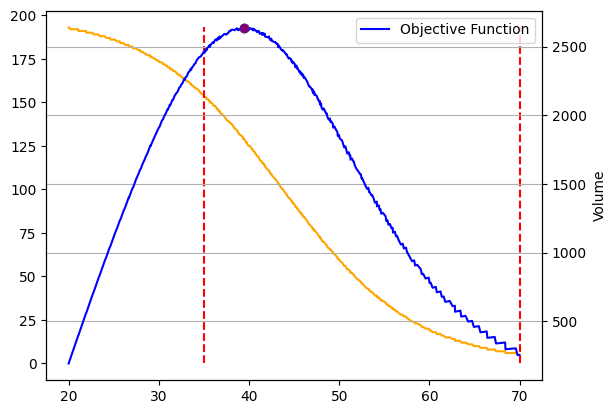

Product ID: APP002
75.67936903803569
75.67936887750595
109.86
50.04


<Figure size 800x500 with 0 Axes>

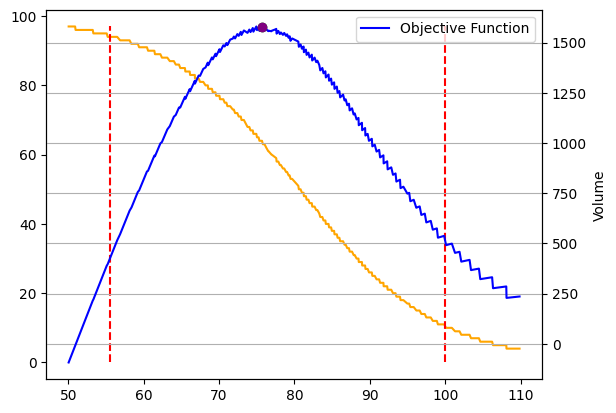

Product ID: APP003
61.91175684712575
61.91175577737907
89.9
45.01


<Figure size 800x500 with 0 Axes>

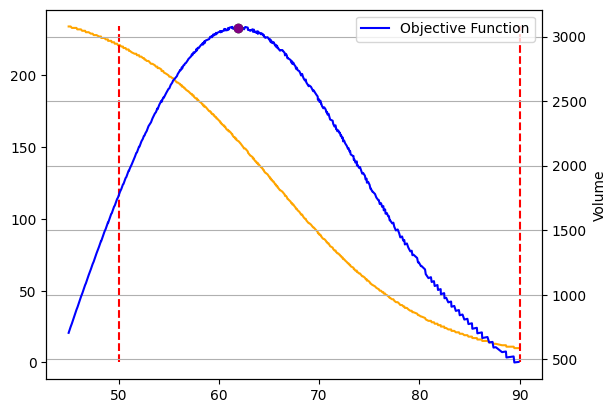

Product ID: BEAU001
10.686551185907641
10.68655015061057
15.0
8.03


<Figure size 800x500 with 0 Axes>

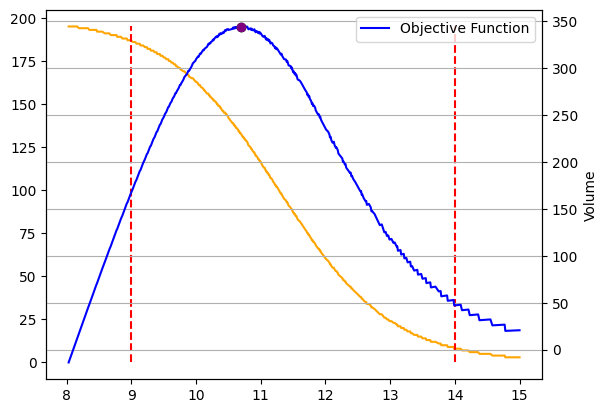

Product ID: BEAU002
25.842562469587794
25.842562633676025
39.99
20.05


<Figure size 800x500 with 0 Axes>

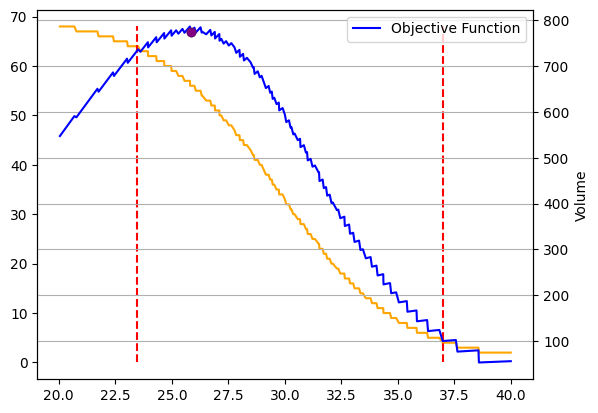

Product ID: BEAU003
40.88652928974441
40.8865292561377
59.96
30.0


<Figure size 800x500 with 0 Axes>

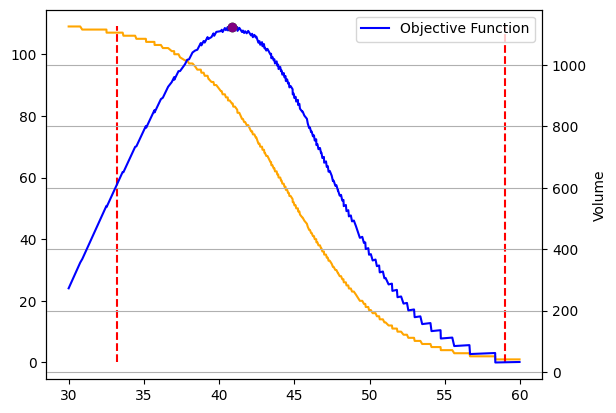

Product ID: ELEC001
98.42066722259658
98.42066721138626
119.98
80.31


<Figure size 800x500 with 0 Axes>

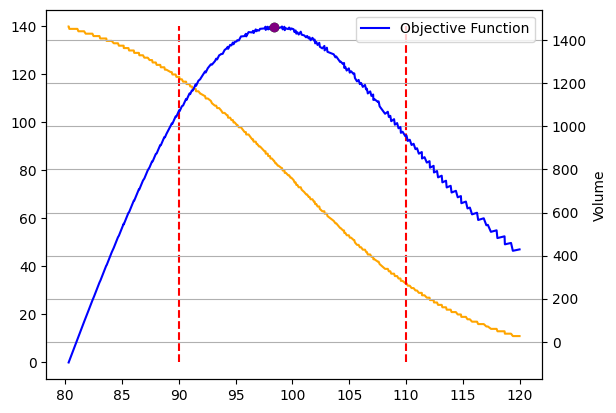

Product ID: ELEC002
356.33193511078946
356.3319350204882
449.69
300.06


<Figure size 800x500 with 0 Axes>

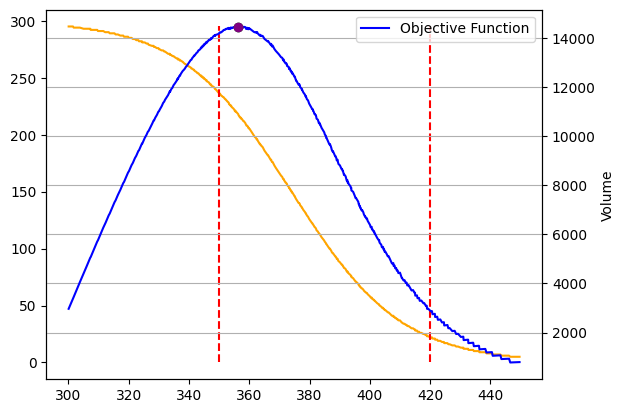

Product ID: ELEC003
130.28487569212874
130.28487713498137
179.96
100.06


<Figure size 800x500 with 0 Axes>

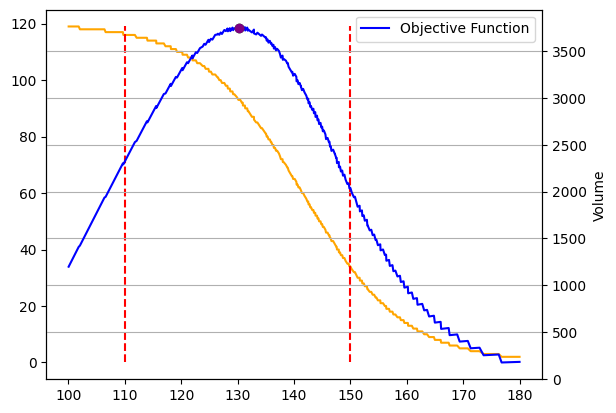

Product ID: HOME001
49.99999217289893
54.064493901944566
79.93
40.06


<Figure size 800x500 with 0 Axes>

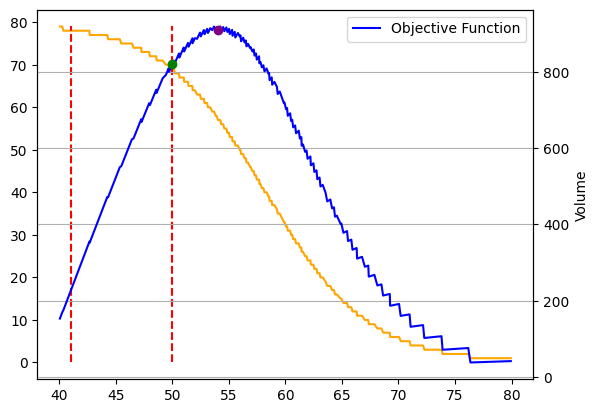

Product ID: HOME002
83.20451646603145
83.2045155418969
119.91
60.45


<Figure size 800x500 with 0 Axes>

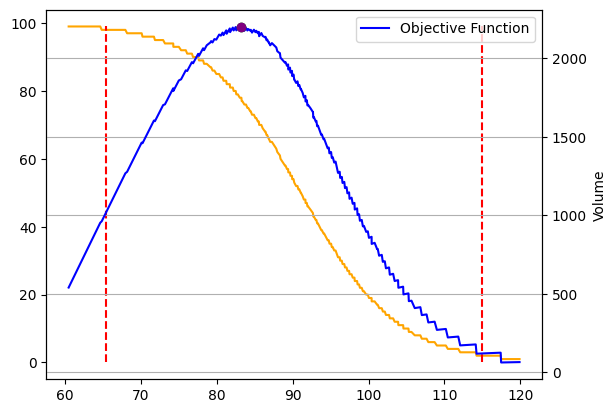

Product ID: HOME003
70.60789976734004
70.60790049081895
99.99
50.01


<Figure size 800x500 with 0 Axes>

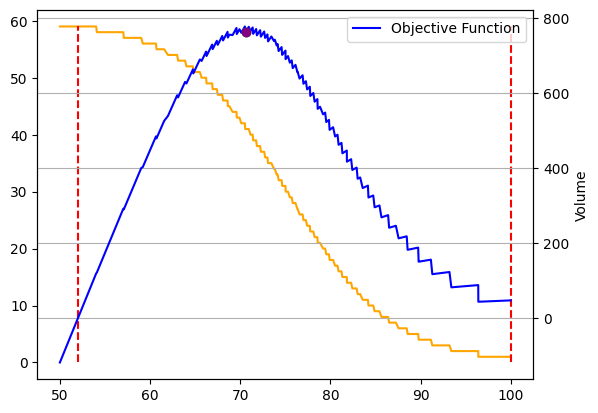

Product ID: SPORT001
25.436578035035986
25.43657992489905
34.95
20.0


<Figure size 800x500 with 0 Axes>

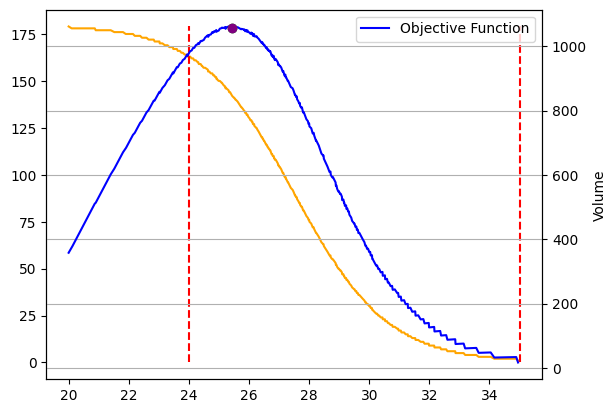

Product ID: SPORT002
59.54019941630957
59.540199862641444
89.86
40.0


<Figure size 800x500 with 0 Axes>

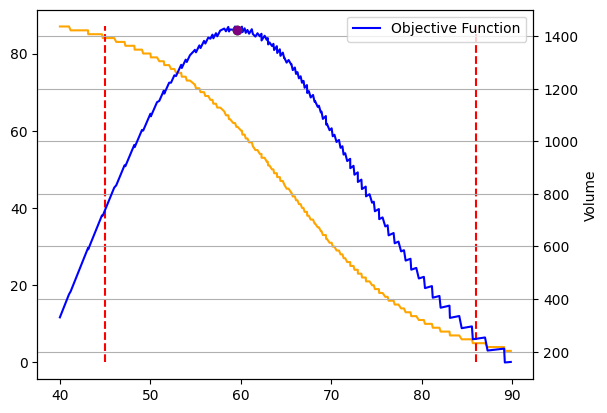

Product ID: SPORT003
93.52136660930893
93.52136971626526
129.95
70.09


<Figure size 800x500 with 0 Axes>

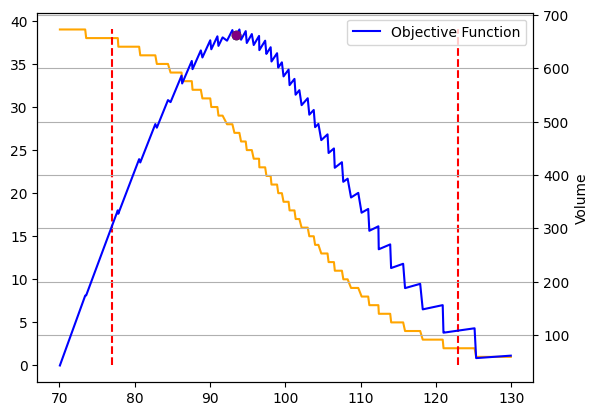

In [24]:
def test(df: pl.DataFrame) -> pl.DataFrame:
    """ """
    volumes = []

    for product_id in df[Column.SKU.value].unique().sort().to_numpy():
        print(f"Product ID: {product_id}")
        products = df.filter(pl.col(Column.SKU.value) == product_id).sort(
            pl.col(Column.CURRENT_PRICE.value)
        )

        # Get the cost of the product
        costs = products[Column.UNIT_COST.value].to_numpy()
        # Get the current prices of the product
        current_prices = products[Column.CURRENT_PRICE.value].to_numpy()

        # Get the units sold of the product
        units_sold = products[Column.UNITS_SOLD.value].to_numpy()

        # Get the price bounds of the product
        price_bounds = PRODUCT_PRICE_RANGES_CONSTRAINTS[product_id]

        # Get the suggested price for the product
        suggested_price = products[Column.SUGGESTED_PRICE.value].to_numpy()[0]

        # Compute margins
        margins = current_prices - costs
        margins *= units_sold

        # Get the optimal price for the product
        optimal_price = products[Column.GLOBAL_OPTIMAL_PRICE.value].to_numpy()[0]

        print(suggested_price)
        print(optimal_price)
        print(current_prices.max())
        print(current_prices.min())

        # Plot
        plt.figure(figsize=(8, 5))
        _, ax1 = plt.subplots()
        ax2 = ax1.twinx()

        ax1.plot(current_prices, units_sold, label="Current Sales", color="orange")
        ax2.plot(current_prices, margins, label="Objective Function", color="blue")

        y_max = np.max(units_sold)

        ax1.vlines(
            price_bounds[0],
            ymin=0,
            ymax=y_max,
            color="red",
            linestyle="--",
        )
        ax1.vlines(
            price_bounds[1],
            ymin=0,
            ymax=y_max,
            color="red",
            linestyle="--",
        )

        suggested_net_margin = (suggested_price - costs[0]) * products[
            Column.EXPECTED_UNITS_SOLD.value
        ][0]
        optimal_net_margin = (optimal_price - costs[0]) * products[
            Column.OPTIMAL_UNITS_SOLD.value
        ][0]

        plt.plot(
            suggested_price,
            suggested_net_margin,
            marker="o",
            color="green",
        )
        plt.plot(
            optimal_price,
            optimal_net_margin,
            marker="o",
            color="purple",
        )
        plt.xlabel("Price")
        plt.ylabel("Volume")
        plt.grid(True)
        plt.legend()
        plt.show()


test(df)


Product ID: SPORT003


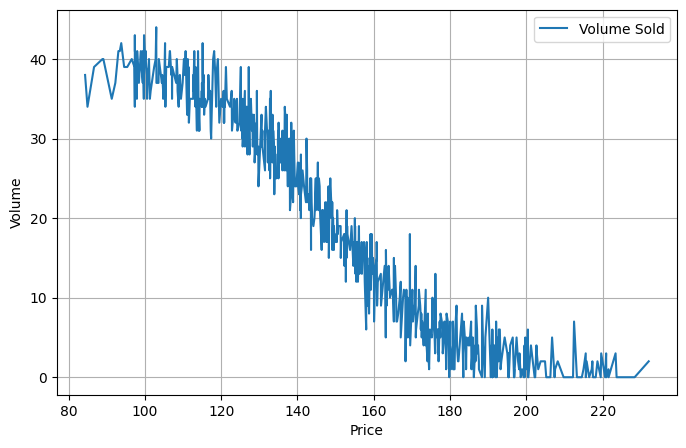

In [ ]:
def plot_demand_curve_for_product():
    # Filter product info using Polars
    for product_id in df[Column.SKU.value].unique().to_numpy():
        print(f"Product ID: {product_id}")
        products = df.filter(pl.col(Column.SKU.value) == product_id).sort(
            pl.col(Column.CURRENT_PRICE.value)
        )

        current_prices = products[Column.CURRENT_PRICE.value].to_numpy()
        units_sold = products[Column.UNITS_SOLD.value].to_numpy()

        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(current_prices, units_sold, label="Volume Sold")
        plt.xlabel("Price")
        plt.ylabel("Volume")
        plt.grid(True)
        plt.legend()
        plt.show()
        break


plot_demand_curve_for_product()

In [ ]:
def fit__curve_for_product():
    # Filter product info using Polars
    for product_id in df[Column.SKU.value].unique().to_numpy():
        print(f"Product ID: {product_id}")
        products = df.filter(pl.col(Column.SKU.value) == product_id).sort(
            pl.col(Column.CURRENT_PRICE.value)
        )

        current_prices = products[Column.CURRENT_PRICE.value].to_numpy()
        units_sold = products[Column.UNITS_SOLD.value].to_numpy()
        obj = env.objective_function(current_prices, units_sold)
        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(current_prices, units_sold, label="Volume Sold")
        plt.xlabel("Price")
        plt.ylabel("Volume")
        plt.grid(True)
        plt.legend()
        plt.show()
        break


plot_demand_curve_for_product()

NameError: name 'plot_demand_curve_for_product' is not defined

In [14]:
json_dashboard_table = json.load(open(DASHBOARD_TABLE_JSON, "r"))


In [15]:
keys = list(json_dashboard_table.keys())
dashboard_table = []
for i in range(len(json_dashboard_table[keys[0]])):
    dashboard_table_row = {}
    for key in keys:
        dashboard_table_row[to_camel_case(key)] = json_dashboard_table[key][i]
    dashboard_table.append(dashboard_table_row)
dashboard_table

[{'sku': 'APP001',
  'productName': 'Denim Jeans',
  'productCategory': 'Apparel',
  'unitsSold': 64962,
  'expectedUnitsSold': 85398,
  'optimalUnitsSold': 85398,
  'currentNetMargin': 980959.9699999989,
  'expectedNetMarginExpectedVolume': 1744820.203844725,
  'optimalNetMargin': 1744819.9925216674,
  'currentRevenue': 2215237.970000001,
  'expectedRevenueExpectedVolume': 3367382.203844726,
  'costs': 1234278.0},
 {'sku': 'HOME003',
  'productName': 'Cookware Set',
  'productCategory': 'Home & Kitchen',
  'unitsSold': 19019,
  'expectedUnitsSold': 25994,
  'optimalUnitsSold': 25994,
  'currentNetMargin': 243298.81999999995,
  'expectedNetMarginExpectedVolume': 483693.74655223306,
  'optimalNetMargin': 483693.76535835565,
  'currentRevenue': 1232286.8200000005,
  'expectedRevenueExpectedVolume': 1835381.7465522534,
  'costs': 988988.0},
 {'sku': 'SPORT001',
  'productName': 'Yoga Mat',
  'productCategory': 'Sports & Outdoors',
  'unitsSold': 59157,
  'expectedUnitsSold': 94004,
  'opt